In [7]:
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as pt
from pytensor.scan import scan
from sklearn.preprocessing import StandardScaler
import arviz as az
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

# Charger le CSV avec parsing de la date
df = pd.read_csv("C:/Users/ADMIN/Desktop/building6pre.csv", parse_dates=["Date"])
df.columns = ["Date", "OAT", "Energy_kW"]

# Mettre la date en index
df = df.set_index("Date")

# Filtrer 2 semaines : du 2 janvier au 15 janvier (inclus)
df_subset = df["2009-01-02":"2009-01-15"].copy()

# Vérification
print(df_subset.shape)
print(df_subset.head())


(336, 2)
                      OAT  Energy_kW
Date                                
2009-01-02 00:00:00  41.6       23.3
2009-01-02 01:00:00  40.9       23.1
2009-01-02 02:00:00  39.5       23.7
2009-01-02 03:00:00  36.3       29.1
2009-01-02 04:00:00  32.8       35.6


In [6]:
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()
scaler_x = StandardScaler()

y = scaler_y.fit_transform(df_subset[["Energy_kW"]]).flatten()
x = scaler_x.fit_transform(df_subset[["OAT"]]).flatten()
n = len(y)

In [8]:
# 3. Modèle ARMAX(1,1) bayésien avec incertitude
with pm.Model() as armax_model:
    # Données partagées
    x_shared = pm.MutableData("x", x)
    y_shared = pm.MutableData("y", y)

    # Priors sur les paramètres
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    phi   = pm.Normal("phi", mu=0, sigma=1)       # AR(1)
    theta = pm.Normal("theta", mu=0, sigma=1)     # MA(1)
    beta  = pm.Normal("beta", mu=0, sigma=1)      # variable exogène (OAT)
    sigma = pm.HalfNormal("sigma", sigma=1)       # bruit

    # Valeur initiale
    mu_0 = alpha + beta * x_shared[0]
    eps_0 = pm.Normal("eps_0", mu=0, sigma=1)

    # Préparation des séquences
    x_seq = x_shared[1:]
    y_tm1 = y_shared[:-1]
    eps_init = pt.concatenate([[eps_0], pt.zeros_like(x_seq[1:])])  # eps_1 à eps_n-1

    # Fonction de transition pour scan
    def step(x_t, y_tm1, eps_tm1, mu_tm1, alpha, beta, phi, theta):
        mu_t = alpha + beta * x_t + phi * y_tm1 + theta * eps_tm1
        eps_t = y_tm1 - mu_tm1
        return mu_t, eps_t

    # Application récursive
    (mu_seq, eps_seq), _ = scan(
        fn=step,
        sequences=[x_seq, y_tm1, eps_init],
        outputs_info=[mu_0, None],
        non_sequences=[alpha, beta, phi, theta]
    )

    # Concaténation pour reconstruire mu complet
    mu = pt.concatenate([[mu_0], mu_seq])

    # Vraisemblance : y_t ~ N(mu_t, sigma)
    pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_shared)

    # Inférence par MCMC
    trace = pm.sample(500, tune=500, target_accept=0.95, cores=2, random_seed=42)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, phi, theta, beta, sigma, eps_0]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 125 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


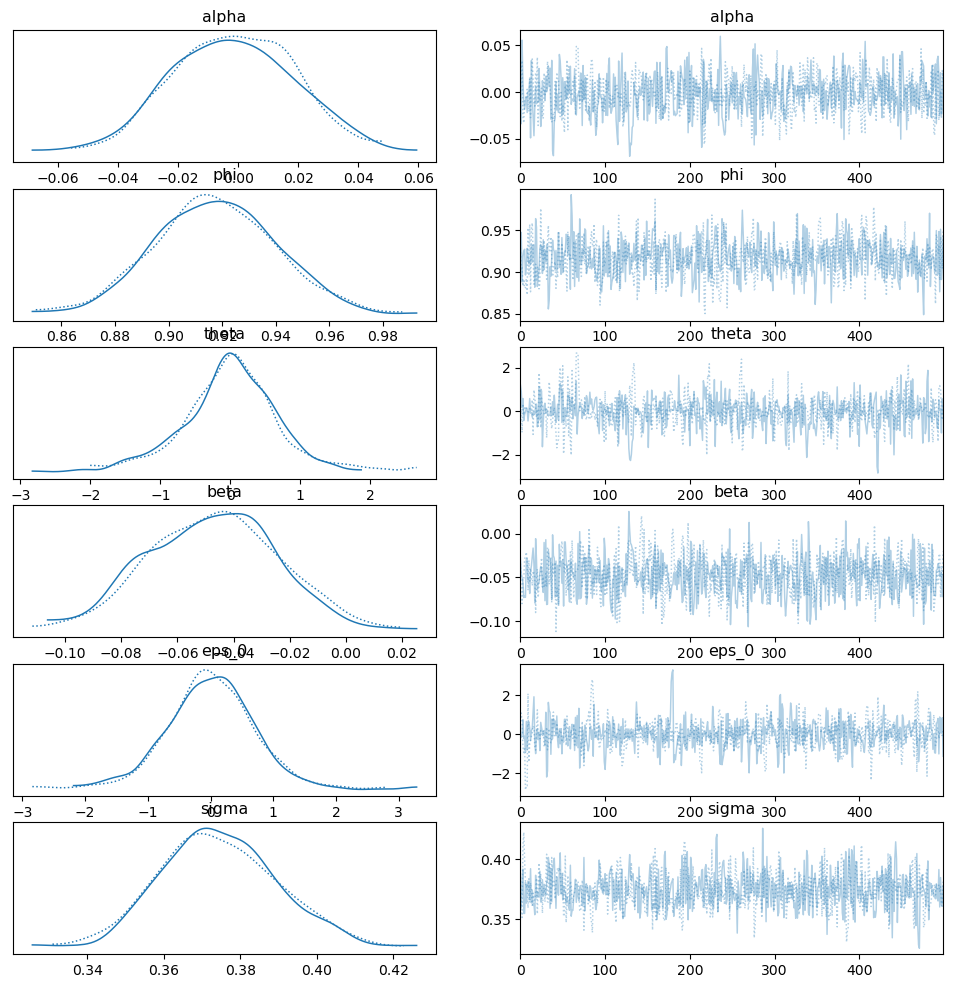

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -0.00  0.02   -0.04     0.04       0.00     0.00    842.94    542.48   
phi    0.92  0.02    0.88     0.96       0.00     0.00    916.55    786.07   
theta  0.00  0.71   -1.46     1.38       0.03     0.03    837.53    467.37   
beta  -0.05  0.02   -0.09    -0.01       0.00     0.00    986.81    775.18   
eps_0 -0.00  0.73   -1.42     1.33       0.03     0.04    784.99    569.40   
sigma  0.37  0.02    0.35     0.40       0.00     0.00    972.82    675.05   

       r_hat  
alpha   1.01  
phi     1.00  
theta   1.00  
beta    1.00  
eps_0   1.00  
sigma   1.00  


In [9]:
# 4. Tracés et résumé
az.plot_trace(trace)
plt.show()

print(az.summary(trace, round_to=2))